## Binary classification with Lightweight CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset


### 1. Import libraries

In [1]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data 
- We train using the training set and save the model that gives the best performance on the validation set

In [3]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. Lightweight CNN model

Let's define our simple CNN architecture which has one conv layer and one FC layer

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length,k_val=5,out_chan_total=59):
        super(CNN_Model, self).__init__()
        self.stride=1
        self.k_val=k_val
        self.out_chan_total=out_chan_total
        # conv: (chan x signal)--> (out chan x signal/stride)
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=self.out_chan_total, 
                               kernel_size=2*self.k_val+self.stride, stride=self.stride,
                               padding=self.k_val)
        # pool: (out chan x signal/stride) --> (out chan x 1)
        self.pool1 = nn.AvgPool1d(kernel_size=int(signal_length/self.stride))
        self.input_s=int(self.out_chan_total)
        self.fc = nn.Linear(self.input_s, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = x.view(-1, self.input_s)
        x=self.fc(x)
        return x

### 5. Initialize Parameters

In [5]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]


Running on: cpu


### 6. Configure Training

In [6]:
batch_size = 2#1
num_epochs = 80
lrate=1e-4
patience=80 # no early stopping from paper
# Define loss function and optimizer
criterion = nn.BCELoss()


### 7. Prepare data

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model while varying kernel size

In [8]:
%%capture

k_list=np.array([5,7,9,11,13,15,17,19])
kernel_list=2*k_list+1
acc_all=[]
recall_all=[]
prec_all=[]
f1_all=[]
auc_all=[]
total_params=[]
for kval in k_list:

    model = CNN_Model(n_chan,n_datalength,k_val=kval,out_chan_total=n_chan)
    model.to(device)
    model_params = sum(p.numel() for p in model.parameters())
    total_params.append(model_params)
    kernel=2*kval+1
    mname='light_cnn_ablation_k_'+str(kernel)+'.pt'
    optimizer = optim.Adam(model.parameters(), lr=lrate)
    cnn_modelfullpath=os.path.join(cnn_modelpath,mname)
    training_arg={
        'modelfullpath': cnn_modelfullpath,
        'criterion': criterion,
        'optimizer': optimizer,
        'epochs': num_epochs,
        'patience': patience,
        'seed': random_seed
    }
    results= model_trainer(model,train_loader,val_loader,training_arg)

    test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
    cm, recall,precision,f1,auc=perf_metrics(test_labels, test_est,test_scores)
    acc_all.append(test_accuracy/100)
    recall_all.append(recall)
    prec_all.append(precision)
    f1_all.append(f1)
    auc_all.append(auc)


Plot performance metric vs kernel size

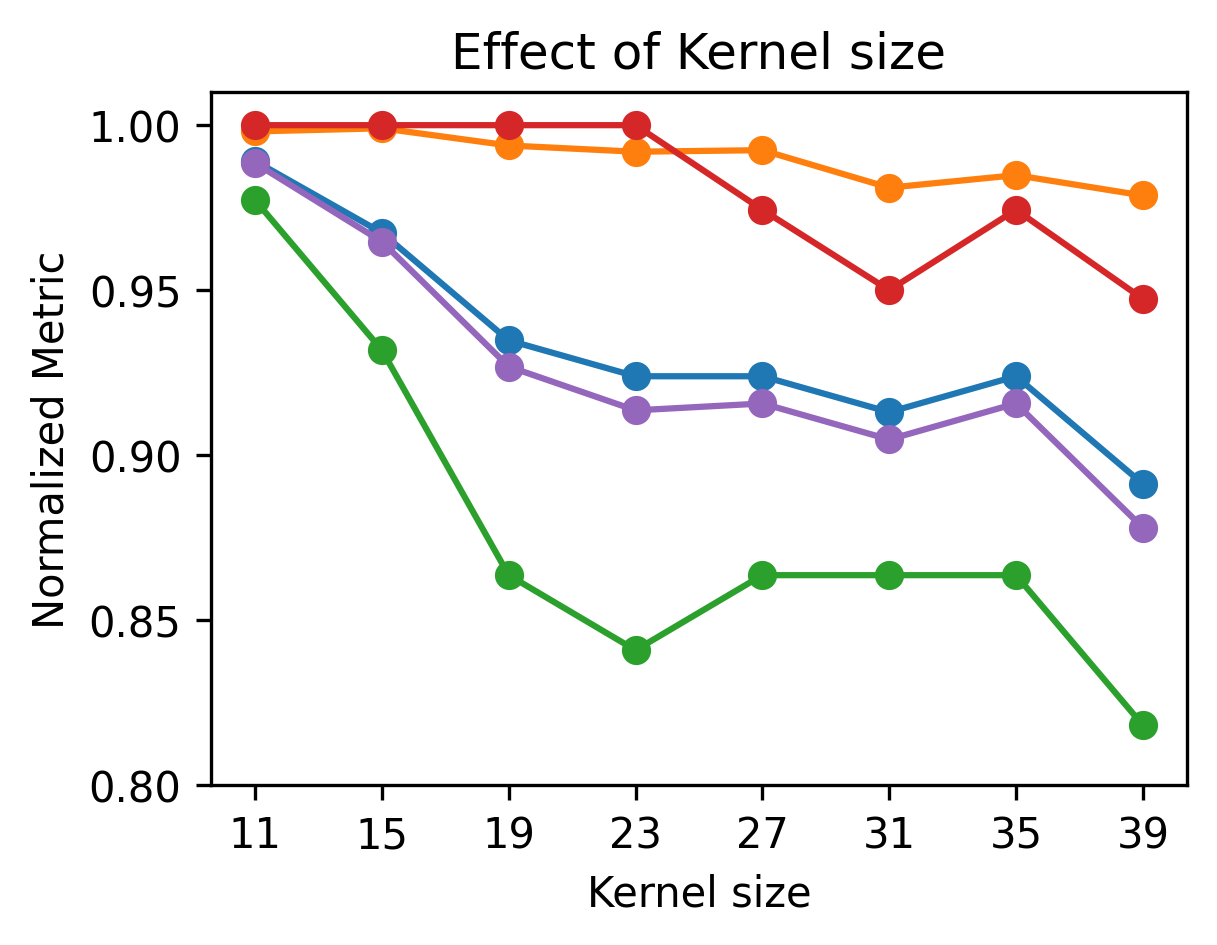

In [22]:
plt.figure(figsize=(4.2, 3),dpi=300)
plt.plot(kernel_list, acc_all,alpha=1,linewidth=1.5,marker='o',label='Accuracy')
plt.plot(kernel_list, auc_all,alpha=1,linewidth=1.5,marker='o',label='AUC')
plt.plot(kernel_list, recall_all,alpha=1,linewidth=1.5,marker='o',label='Recall')
plt.plot(kernel_list, prec_all,alpha=1,linewidth=1.5,marker='o',label='Precision')
plt.plot(kernel_list, f1_all,alpha=1,linewidth=1.5,marker='o',label='F1-score')
plt.xlabel(r'Kernel size')
plt.ylabel(r'Normalized Metric')
plt.title('Effect of Kernel size')
plt.ylim([0.8, 1.01])
#plt.xlim([11,39])
plt.xticks(kernel_list)
#plt.legend()
plt.grid(False)
plt.show()

Some stats

In [15]:
def print_stats(smetric,name):
    print(f'{name}: min {np.min(smetric):.4f}| max {np.max(smetric):.4f} | std {np.std(smetric):.4f} | avg {np.mean(smetric):.4f} ')

print_stats(acc_all,'ACC')
print_stats(recall_all,'REC')
print_stats(prec_all,'PRE')
print_stats(f1_all,'F1-')
print_stats(auc_all,'AUC')


ACC: min 0.8913| max 0.9891 | std 0.0290 | avg 0.9334 
REC: min 0.8182| max 0.9773 | std 0.0481 | avg 0.8778 
PRE: min 0.9474| max 1.0000 | std 0.0213 | avg 0.9808 
F1-: min 0.8780| max 0.9885 | std 0.0326 | avg 0.9260 
AUC: min 0.9787| max 0.9991 | std 0.0071 | avg 0.9900 


In [16]:
print(f'KER: {kernel_list}')
print(f'ACC: {acc_all}')
print(f'REC: {recall_all}')
print(f'PRE: {prec_all}')
print(f'F1-: {f1_all}')
print(f'AUC: {auc_all}')
print(f'Params: {total_params}')

KER: [11 15 19 23 27 31 35 39]
ACC: [0.9891304347826086, 0.967391304347826, 0.9347826086956522, 0.923913043478261, 0.923913043478261, 0.9130434782608695, 0.923913043478261, 0.8913043478260869]
REC: [0.9772727272727273, 0.9318181818181818, 0.8636363636363636, 0.8409090909090909, 0.8636363636363636, 0.8636363636363636, 0.8636363636363636, 0.8181818181818182]
PRE: [1.0, 1.0, 1.0, 1.0, 0.9743589743589743, 0.95, 0.9743589743589743, 0.9473684210526315]
F1-: [0.9885057471264368, 0.9647058823529412, 0.9268292682926829, 0.9135802469135803, 0.9156626506024097, 0.9047619047619048, 0.9156626506024097, 0.8780487804878049]
AUC: [0.9981060606060606, 0.9990530303030304, 0.993844696969697, 0.9919507575757576, 0.9924242424242424, 0.981060606060606, 0.9848484848484849, 0.9786931818181819]
Params: [38470, 52394, 66318, 80242, 94166, 108090, 122014, 135938]


### 9. Train model while varying conv layer output channel size

In [17]:
%%capture

chan_list=[20,25,30,35,40,45,50,55,59]

acc_all2=[]
recall_all2=[]
prec_all2=[]
f1_all2=[]
auc_all2=[]
total_params2=[]
for out_chan in chan_list:

    model = CNN_Model(n_chan,n_datalength,k_val=5,out_chan_total=out_chan)
    model.to(device)
    model_params = sum(p.numel() for p in model.parameters())
    total_params2.append(model_params)

    mname='light_cnn_ablation_outchan_'+str(out_chan)+'.pt'
    optimizer = optim.Adam(model.parameters(), lr=lrate)
    cnn_modelfullpath=os.path.join(cnn_modelpath,mname)
    training_arg={
        'modelfullpath': cnn_modelfullpath,
        'criterion': criterion,
        'optimizer': optimizer,
        'epochs': num_epochs,
        'patience': patience,
        'seed': random_seed
    }
    results= model_trainer(model,train_loader,val_loader,training_arg)

    test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
    cm, recall,precision,f1,auc=perf_metrics(test_labels, test_est,test_scores)
    acc_all2.append(test_accuracy/100)
    recall_all2.append(recall)
    prec_all2.append(precision)
    f1_all2.append(f1)
    auc_all2.append(auc)

Plot performance metric vs conv layer output channel size

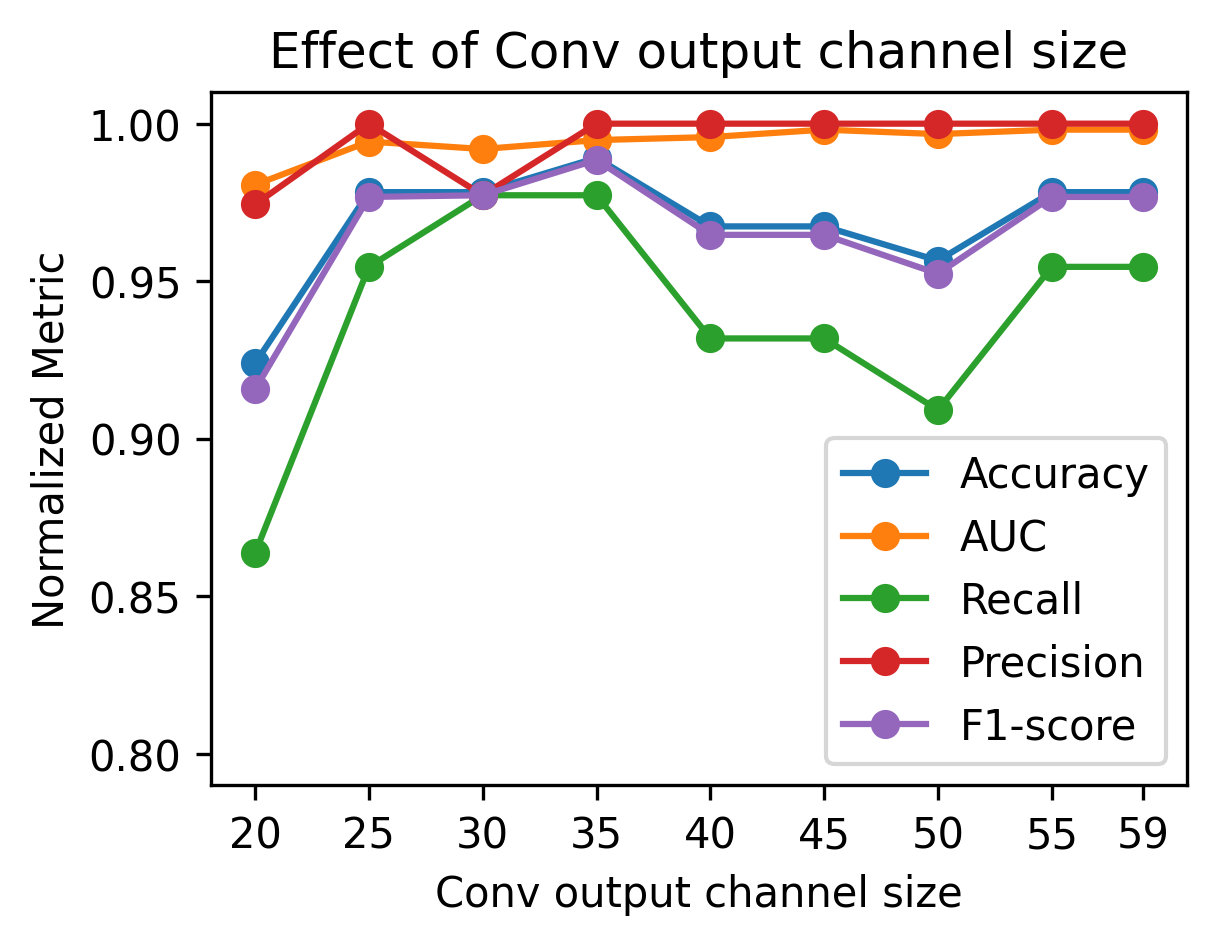

In [23]:
plt.figure(figsize=(4.2, 3),dpi=300)
plt.plot(chan_list, acc_all2,alpha=1,linewidth=1.5,marker='o',label='Accuracy')
plt.plot(chan_list, auc_all2,alpha=1,linewidth=1.5,marker='o',label='AUC')
plt.plot(chan_list, recall_all2,alpha=1,linewidth=1.5,marker='o',label='Recall')
plt.plot(chan_list, prec_all2,alpha=1,linewidth=1.5,marker='o',label='Precision')
plt.plot(chan_list, f1_all2,alpha=1,linewidth=1.5,marker='o',label='F1-score')
plt.xlabel(r'Conv output channel size')
plt.ylabel(r'Normalized Metric')
plt.title('Effect of Conv output channel size')
plt.ylim([0.79, 1.01])
plt.xticks(chan_list)
plt.legend()
plt.grid(False)
plt.show()

Some stats

In [24]:
print_stats(acc_all2,'ACC')
print_stats(recall_all2,'REC')
print_stats(prec_all2,'PRE')
print_stats(f1_all2,'F1-')
print_stats(auc_all2,'AUC')

ACC: min 0.9239| max 0.9891 | std 0.0181 | avg 0.9686 
REC: min 0.8636| max 0.9773 | std 0.0339 | avg 0.9394 
PRE: min 0.9744| max 1.0000 | std 0.0101 | avg 0.9946 
F1-: min 0.9157| max 0.9885 | std 0.0203 | avg 0.9659 
AUC: min 0.9806| max 0.9981 | std 0.0052 | avg 0.9943 


In [25]:
print(f'KER: {chan_list}')
print(f'ACC: {acc_all2}')
print(f'REC: {recall_all2}')
print(f'PRE: {prec_all2}')
print(f'F1-: {f1_all2}')
print(f'AUC: {auc_all2}')
print(f'Params: {total_params2}')

KER: [20, 25, 30, 35, 40, 45, 50, 55, 59]
ACC: [0.923913043478261, 0.9782608695652173, 0.9782608695652173, 0.9891304347826086, 0.967391304347826, 0.967391304347826, 0.9565217391304348, 0.9782608695652173, 0.9782608695652173]
REC: [0.8636363636363636, 0.9545454545454546, 0.9772727272727273, 0.9772727272727273, 0.9318181818181818, 0.9318181818181818, 0.9090909090909091, 0.9545454545454546, 0.9545454545454546]
PRE: [0.9743589743589743, 1.0, 0.9772727272727273, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1-: [0.9156626506024097, 0.9767441860465117, 0.9772727272727273, 0.9885057471264368, 0.9647058823529412, 0.9647058823529412, 0.9523809523809523, 0.9767441860465117, 0.9767441860465117]
AUC: [0.9805871212121211, 0.9943181818181819, 0.9919507575757576, 0.9947916666666667, 0.9957386363636364, 0.9981060606060606, 0.996685606060606, 0.9981060606060606, 0.9981060606060606]
Params: [13042, 16302, 19562, 22822, 26082, 29342, 32602, 35862, 38470]
